# NbConvert, Python library

In this Notebook, I will introduce you to the programatic API of nbconvert to show you how to use it in various context. 

For this I will use one of [@jakevdp](https://github.com/jakevdp) great [blog post](http://jakevdp.github.io/blog/2013/04/15/code-golf-in-python-sudoku/).
I've explicitely chosen a post with no javascript tricks as Jake seem to be found of right now, for the reason that the becommings of embeding javascript in nbviewer, which is based on nbconvert is not fully decided yet. 


This will not focus on using the command line tool to convert file. The attentive reader will point-out that no data are read from, or written to disk during the conversion process. Indeed, nbconvert as been though as much as
possible to avoid IO operation and work as well in a database, or web-based environement.

#### Quick overview

Credit, Jonathan Freder (@jdfreder on github)

<center>
 ![nbca](images/nbconvert_arch.png)
</center>

The main principle of nbconvert is to instanciate a `Exporter` that controle
a pipeline through which each notebook you want to export with go through.

Let's start by importing what we need from the API, and download @jakevdp's notebook.

In [1]:
import requests
response = requests.get('http://jakevdp.github.com/downloads/notebooks/XKCD_plots.ipynb')
response.text[0:60]+'...'

'{\n "metadata": {\n  "name": "XKCD_plots"\n },\n "nbformat": 3,\n...'

If you do not have request install downlad by hand, and read the file as usual.

We read the response into a slightly more convenient format which represent IPython notebook. 
There are not real advantages for now, except some convenient methods, but with time this structure should be able to
guarantee that the notebook structure is valid. Note also that the in-memory format and on disk format can be slightly different. In particual, on disk, multiline strings might be spitted into list of string to be more version control friendly.

In [2]:
from IPython import nbformat
jake_notebook = nbformat.reads(response.text, as_version=4)
jake_notebook.cells[0]

{'cell_type': 'markdown',
 'metadata': {},
 'source': '# XKCD plots in Matplotlib'}

So we have here Jake's notebook in a convenient form, which is mainly a Super-Powered dict and list nested.
You don't need to worry about the exact structure.

The nbconvert API exposes some basic exporter for common format and default options. We will start
by using one of them. First we import it, instanciate an instance with most of the default parameters and fed it
the downloaded notebook. 

In [3]:
from IPython.config import Config
from IPython.nbconvert import HTMLExporter

## I use `basic` here to have less boilerplate and headers in the HTML.
## we'll see later how to pass config to exporters.
html_exporter = HTMLExporter(config=Config({'HTMLExporter':{'default_template':'basic'}}))

In [4]:
(body, resources) = html_exporter.from_notebook_node(jake_notebook)

The exporter returns a tuple containing the body of the converted notebook, here raw HTML, as well as a resources dict.
The resource dict contains (among many things) the extracted PNG, JPG [...etc] from the notebook when applicable.
The basic HTML exporter does keep them as embeded base64 into the notebook, but one can do ask the figures to be extracted. Cf advance use. So for now the resource dict **should** be mostly empty, except for 1 key containing some css, and 2 others whose content will be obvious.

Exporter are stateless, you won't be able to extract any usefull information (except their configuration) from them.
You can directly re-use the instance to convert another notebook. Each exporter expose for convenience a `from_file` and `from_filename` methods if you need.

In [5]:
print([key for key in resources ])
print(resources['metadata'])
print(resources['output_extension'])
# print resources['inlining'] # too lng to be shown

['raw_mimetypes', 'inlining', 'metadata', 'output_extension']
defaultdict(None, {'name': 'Notebook'})
.html


In [6]:
# Part of the body, here the first Heading
start = body.index('<h1 id', )
print(body[:400]+'...')

<!DOCTYPE html>
<html>
<head>

<meta charset="utf-8" />
<title>Notebook</title>

<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.1.10/require.min.js"></script>
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js"></script>

<style type="text/css">
    /*!
*
* Twitter Bootstrap
*
*/
/*! normalize.css v3.0.2 | MIT License | git.io/normalize */
html {
  fon...


You can directly write the body into an HTML file if you wish, as you see it does not contains any body tag, or style declaration, but thoses are included in the default HtmlExporter if you do not pass it a config object as I did.

#### Extracting Figures

When exporting one might want to extract the base64 encoded figures to separate files, this is by default what does the RstExporter does, let see how to use it. 

In [7]:
from IPython.nbconvert import RSTExporter

rst_exporter = RSTExporter()

(body,resources) = rst_exporter.from_notebook_node(jake_notebook)

In [8]:
print(body[:970]+'...')
print('[.....]')
print(body[800:1200]+'...')


XKCD plots in Matplotlib

This notebook originally appeared as a blog post at `Pythonic
Perambulations <http://jakevdp.github.com/blog/2012/10/07/xkcd-style-plots-in-matplotlib/>`__
by Jake Vanderplas.

.. raw:: html

   <!-- PELICAN_BEGIN_SUMMARY -->

*Update: the matplotlib pull request has been merged! See* `*This
post* <http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/>`__
*for a description of the XKCD functionality now built-in to
matplotlib!*

One of the problems I've had with typical matplotlib figures is that
everything in them is so precise, so perfect. For an example of what I
mean, take a look at this figure:

.. code:: python

    from IPython.display import Image
    Image('http://jakevdp.github.com/figures/xkcd_version.png')



.. image:: output_3_0.png



Sometimes when showing schematic plots, this is the type of figure I
want to display. But drawing it by hand is a pain: I'd rather just use
matpl...
[.....]
mage:: output_3_0.png



Sometimes when sho

Here we see that base64 images are not embeded, but we get what look like file name. Actually those are (Configurable) keys to get back the binary data from the resources dict we havent inspected earlier.


So when writing a Rst Plugin for any blogengine, Sphinx or anything else, you will be responsible for writing all those data to disk, in the right place. 
Of course to help you in this task all those naming are configurable in the right place.

let's try to see how to get one of these images

In [9]:
list(resources['outputs'])

['output_5_0.png',
 'output_16_0.png',
 'output_13_1.png',
 'output_18_1.png',
 'output_3_0.png']

We have extracted 5 binary figures, here `png`s, but they could have been svg, and then wouldn't appear in the binary sub dict.
keep in mind that a object having multiple _repr_ will store all it's repr in the notebook. 

Hence if you provide `_repr_javascript_`,`_repr_latex_` and `_repr_png_`to an object, you will be able to determine at conversion time which representaition is the more appropriate. You could even decide to show all the representaition of an object, it's up to you. But this will require beeing a little more involve and write a few line of Jinja template. This will probably be the subject of another tutorial.

Back to our images,



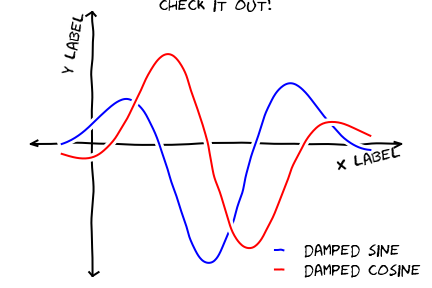

In [10]:
from IPython.display import Image
Image(data=resources['outputs']['output_3_0.png'],format='png')

Yep, this is indeed the image we were expecting, and I was able to see it without ever writing or reading it from disk. I don't think I'll have to show to you what to do with those data, as if you are here you are most probably familiar with IO.

## Extracting figures with HTML Exporter ?

Use case:

> I write an [awesome blog](http://jakevdp.github.io/) in HTML, and I want all but having base64 embeded images. 
Having one html file with all inside is nice to send to coworker, but I definitively want resources to be cached !
So I need an HTML exporter, and I want it to extract the figures !

### Some theory

The process of converting a notebook to a another format with the nbconvert Exporters happend in a few steps:

  - Get the notebook data and other required files. (you are responsible for that)
  - Feed them to the exporter that will
      - sequentially feed the data to a number of `Preprocessors`. Preprocessor only act on the **structure**
      of the notebook, and have access to it all. 
      - feed the notebook through the jinja templating engine
          - the use templates are configurable.
          - templates make use of configurable macros called filters.
  - The exporter return the converted notebook as well as other relevant resources as a tuple.
  - Write what you need to disk, or elsewhere. (You are responsible for it)

Here we'll be interested in the `Preprocessors`. Each `Preprocessor` is applied successively and in order on the notebook before going through the conversion process.

We provide some preprocessor that do some modification on the notebook structure by default.
One of them, the `ExtractOutputPreprocessor` is responsible for crawling notebook,
finding all the figures, and put them into the resources directory, as well as choosing the key
(`filename_xx_y.extension`) that can replace the figure in the template.


The `ExtractOutputPreprocessor` is special in the fact that it **should** be availlable on all `Exporter`s, but is just inactive by default on some exporter.

In [11]:
# 3rd one should be <ExtractOutputPreprocessor>
html_exporter._preprocessors

[<function IPython.nbconvert.preprocessors.coalescestreams.cell_preprocessor.<locals>.wrappedfunc>,

To enable it we will use IPython configuration/Traitlets system. If you are have already set some IPython configuration options, 
this will look pretty familiar to you. Configuration option are always of the form:

    ClassName.attribute_name = value
   
A few ways exist to create such config, like reading a config file in your profile, but you can also do it programatically usign a dictionary. Let's create such a config object, and see the difference if we pass it to our `HTMLExporter`

In [12]:
from IPython.config import Config

c =  Config({
            'ExtractOutputPreprocessor':{'enabled':True}
            })

exportHTML = HTMLExporter()
exportHTML_and_figs = HTMLExporter(config=c)

(_, resources)          = exportHTML.from_notebook_node(jake_notebook)
(_, resources_with_fig) = exportHTML_and_figs.from_notebook_node(jake_notebook)

print('resources without the "figures" key :')
print(list(resources))

print('')
print('Here we have one more field')
print(list(resources_with_fig))
list(resources_with_fig['outputs'])

resources without the "figures" key :
['raw_mimetypes', 'inlining', 'metadata', 'output_extension']

Here we have one more field
['outputs', 'raw_mimetypes', 'inlining', 'metadata', 'output_extension']


['output_5_0.png',
 'output_16_0.png',
 'output_13_1.png',
 'output_18_1.png',
 'output_3_0.png']

So now you can loop through the dict and write all those figures to disk in the right place... 

#### Custom Preprocessor

Of course you can imagine many transformation that you would like to apply to a notebook. This is one of the reason we provide a way to register your own preprocessors that will be applied to the notebook after the default ones.

To do so you'll have to pass an ordered list of `Preprocessor`s to the Exporter constructor. 

But what is an preprocessor ? Preprocessor can be either *decorated function* for dead-simple `Preprocessor`s that apply
independently to each cell, for more advance transformation that support configurability You have to inherit from
`Preprocessor` and define a `call` method as we'll see below.

All transforers have a magic attribute that allows it to be activated/disactivate from the config dict.

In [13]:
from IPython.nbconvert.preprocessors import Preprocessor
import IPython.config
print("Four relevant docstring")
print('=============================')
print(Preprocessor.__doc__)
print('=============================')
print(Preprocessor.preprocess.__doc__)
print('=============================')
print(Preprocessor.preprocess_cell.__doc__)
print('=============================')

Four relevant docstring
 A configurable preprocessor

    Inherit from this class if you wish to have configurability for your
    preprocessor.

    Any configurable traitlets this class exposed will be configurable in
    profiles using c.SubClassName.attribute = value

    you can overwrite :meth:`preprocess_cell` to apply a transformation
    independently on each cell or :meth:`preprocess` if you prefer your own
    logic. See corresponding docstring for informations.

    Disabled by default and can be enabled via the config by
        'c.YourPreprocessorName.enabled = True'
    

        Preprocessing to apply on each notebook.
        
        Must return modified nb, resources.
        
        If you wish to apply your preprocessing to each cell, you might want
        to override preprocess_cell method instead.
        
        Parameters
        ----------
        nb : NotebookNode
            Notebook being converted
        resources : dictionary
            Additional re

***
We don't provide convenient method to be aplied on each worksheet as the **data structure** for worksheet will be removed. (not the worksheet functionality, which is still on it's way)
***

### Example

I'll now demonstrate a specific example [requested](https://github.com/ipython/nbconvert/pull/137#issuecomment-18658235) while nbconvert 2 was being developed. The ability to exclude cell from the conversion process based on their index. 

I'll let you imagin how to inject cell, if what you just want is to happend static content at the beginning/end of a notebook, plese refer to templating section, it will be much easier and cleaner.

In [14]:
from IPython.utils.traitlets import Integer

In [15]:
class PelicanSubCell(Preprocessor):
    """A Pelican specific preprocessor to remove somme of the cells of a notebook"""
    
    # I could also read the cells from nbc.metadata.pelican is someone wrote a JS extension
    # But I'll stay with configurable value. 
    start = Integer(0, config=True, help="first cell of notebook to be converted")
    end   = Integer(-1, config=True, help="last cell of notebook to be converted")
    
    def preprocess(self, nb, resources):

        #nbc = deepcopy(nb)
        nbc = nb
        # don't print in real preprocessor !!!
        print("I'll keep only cells from ", self.start, "to ", self.end, "\n\n")
        nbc.cells = nb.cells[self.start:self.end]                    
        return nbc, resources

In [16]:
# I create this on the fly, but this could be loaded from a DB, and config object support merging...
c =  Config()
c.PelicanSubCell.enabled = True
c.PelicanSubCell.start = 4
c.PelicanSubCell.end = 6

I'm creating a pelican exporter that take `PelicanSubCell` extra preprocessors and a `config` object as parameter. This might seem redundant, but with configuration system you'll see that one can register an inactive preprocessor on all exporters and activate it at will form its config files and command line. 

In [17]:
pelican = RSTExporter(preprocessors=[PelicanSubCell], config=c)

In [18]:
print(pelican.from_notebook_node(jake_notebook)[0])

I'll keep only cells from  4 to  6 



Sometimes when showing schematic plots, this is the type of figure I
want to display. But drawing it by hand is a pain: I'd rather just use
matplotlib. The problem is, matplotlib is a bit too precise. Attempting
to duplicate this figure in matplotlib leads to something like this:

.. code:: python

    Image('http://jakevdp.github.com/figures/mpl_version.png')



.. image:: output_5_0.png





### Programatically make templates

In [19]:
from jinja2 import DictLoader

dl = DictLoader({'full.tpl': 
"""
{%- extends 'basic.tpl' -%} 

{% block footer %}
FOOOOOOOOTEEEEER
{% endblock footer %}
"""})


exportHTML = HTMLExporter(extra_loaders=[dl])
(body,resources) = exportHTML.from_notebook_node(jake_notebook)
for l in body.split('\n')[-4:]:
    print(l)

</div>
</div>
FOOOOOOOOTEEEEER



### Real World Use

@jakevdp use Pelican and IPython Notebook to blog. Pelican [Will use](https://github.com/getpelican/pelican-plugins/pull/21) nbconvert programatically to generate blog post. Have a look a [Pythonic Preambulations](http://jakevdp.github.io/) for Jake blog post.

@damianavila Wrote a Nicholas Plugin to [Write blog post as Notebook](http://www.damian.oquanta.info/posts/one-line-deployment-of-your-site-to-gh-pages.html) and is developping a js-extension to publish notebooks in one click from the web app.

<center>
<blockquote class="twitter-tweet"><p>As <a href="https://twitter.com/Mbussonn">@Mbussonn</a> requested... easieeeeer! Deploy your Nikola site with just a click in the IPython notebook! <a href="http://t.co/860sJunZvj">http://t.co/860sJunZvj</a> cc <a href="https://twitter.com/ralsina">@ralsina</a></p>&mdash; Damián Avila (@damian_avila) <a href="https://twitter.com/damian_avila/statuses/370306057828335616">August 21, 2013</a></blockquote>
</center>

And finaly,  what you just did, is replicate what [nbviewer](http://nbviewer.ipython.org) does. WHich to fetch a notebook from url, convert it and send in back to you as a static html.

##### A few gotchas

Jinja blocks use `{% %}`by default which does not play nicely with $\LaTeX$, hence thoses are replaced by `((* *))` in latex templates.